In [5]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/

import pickle
from tqdm import tqdm
import os

from chart_studio import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

from sklearn.tree import DecisionTreeClassifier

In [6]:
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [7]:
'''
# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding="utf8")
    model = {}
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model
model = loadGloveModel('glove.42B.300d.txt')

# ============================
Output:
    
Loading Glove Model
1917495it [06:32, 4879.69it/s]
Done. 1917495  words loaded!

# ============================

words = []
for i in preproced_texts:
    words.extend(i.split(' '))

for i in preproced_titles:
    words.extend(i.split(' '))
print("all the words in the coupus", len(words))
words = set(words)
print("the unique words in the coupus", len(words))

inter_words = set(model.keys()).intersection(words)
print("The number of words that are present in both glove vectors and our coupus", \
      len(inter_words),"(",np.round(len(inter_words)/len(words)*100,3),"%)")

words_courpus = {}
words_glove = set(model.keys())
for i in words:
    if i in words_glove:
        words_courpus[i] = model[i]
print("word 2 vec length", len(words_courpus))


# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

import pickle
with open('glove_vectors', 'wb') as f:
    pickle.dump(words_courpus, f)


'''

'\n# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039\ndef loadGloveModel(gloveFile):\n    print ("Loading Glove Model")\n    f = open(gloveFile,\'r\', encoding="utf8")\n    model = {}\n    for line in tqdm(f):\n        splitLine = line.split()\n        word = splitLine[0]\n        embedding = np.array([float(val) for val in splitLine[1:]])\n        model[word] = embedding\n    print ("Done.",len(model)," words loaded!")\n    return model\nmodel = loadGloveModel(\'glove.42B.300d.txt\')\n\n# ============================\nOutput:\n    \nLoading Glove Model\n1917495it [06:32, 4879.69it/s]\nDone. 1917495  words loaded!\n\n# ============================\n\nwords = []\nfor i in preproced_texts:\n    words.extend(i.split(\' \'))\n\nfor i in preproced_titles:\n    words.extend(i.split(\' \'))\nprint("all the words in the coupus", len(words))\nwords = set(words)\nprint("the unique words in the coupus", len(words))\n\ninter_words = set(model.keys()).intersection(word

### Calculating Sentiment Scores

In [8]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [9]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# import nltk
# nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

for_sentiment = 'a person is a person no matter how small dr seuss i teach the smallest students with the biggest enthusiasm \
for learning my students learn in many different ways using all of our senses and multiple intelligences i use a wide range\
of techniques to help all my students succeed students in my class come from a variety of different backgrounds which makes\
for wonderful sharing of experiences and cultures including native americans our school is a caring community of successful \
learners which can be seen through collaborative student project based learning in and out of the classroom kindergarteners \
in my class love to work with hands on materials and have many different opportunities to practice a skill before it is\
mastered having the social skills to work cooperatively with friends is a crucial aspect of the kindergarten curriculum\
montana is the perfect place to learn about agriculture and nutrition my students love to role play in our pretend kitchen\
in the early childhood classroom i have had several kids ask me can we try cooking with real food i will take their idea \
and create common core cooking lessons where we learn important math and writing concepts while cooking delicious healthy \
food for snack time my students will have a grounded appreciation for the work that went into making the food and knowledge \
of where the ingredients came from as well as how it is healthy for their bodies this project would expand our learning of \
nutrition and agricultural cooking recipes by having us peel our own apples to make homemade applesauce make our own bread \
and mix up healthy plants from our classroom garden in the spring we will also create our own cookbooks to be printed and \
shared with families students will gain math and literature skills as well as a life long enjoyment for healthy cooking \
nannan'
ss = sid.polarity_scores(for_sentiment)
print(ss)
for k in ss:
    print('{0}: {1}, '.format(k, ss[k]), end='')

# we can use these 4 things as features/attributes (neg, neu, pos, compound)
# neg: 0.0, neu: 0.753, pos: 0.247, compound: 0.93

{'neg': 0.01, 'neu': 0.745, 'pos': 0.245, 'compound': 0.9975}
neg: 0.01, neu: 0.745, pos: 0.245, compound: 0.9975, 

<h1>1. Decision Tree </h1>

## 1.1 Loading Data

In [10]:
import pandas
data = pandas.read_csv('preprocessed_data.csv',nrows=50000)

<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [12]:
from sklearn.model_selection import train_test_split
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

<h2>1.3 Make Data Model Ready: encoding essay using TFIDF</h2>

In [13]:
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)

feature_names=[]

vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer.fit(X_train['essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_tfidf = vectorizer.transform(X_train['essay'].values)
X_cv_essay_tfidf = vectorizer.transform(X_cv['essay'].values)
X_test_essay_tfidf = vectorizer.transform(X_test['essay'].values)

feature_names.extend(vectorizer.get_feature_names())

print("After vectorizations")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_cv_essay_tfidf.shape, y_cv.shape)
print(X_test_essay_tfidf.shape, y_test.shape)
print("="*100)

(22445, 8) (22445,)
(11055, 8) (11055,)
(16500, 8) (16500,)
After vectorizations
(22445, 5000) (22445,)
(11055, 5000) (11055,)
(16500, 5000) (16500,)


<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

In [14]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['school_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_state_ohe = vectorizer.transform(X_train['school_state'].values)
X_cv_state_ohe = vectorizer.transform(X_cv['school_state'].values)
X_test_state_ohe = vectorizer.transform(X_test['school_state'].values)

print("After vectorizations")
print(X_train_state_ohe.shape, y_train.shape)
print(X_cv_state_ohe.shape, y_cv.shape)
print(X_test_state_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
feature_names.extend(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(22445, 51) (22445,)
(11055, 51) (11055,)
(16500, 51) (16500,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


In [15]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_ohe = vectorizer.transform(X_train['teacher_prefix'].values)
X_cv_teacher_ohe = vectorizer.transform(X_cv['teacher_prefix'].values)
X_test_teacher_ohe = vectorizer.transform(X_test['teacher_prefix'].values)

print("After vectorizations")
print(X_train_teacher_ohe.shape, y_train.shape)
print(X_cv_teacher_ohe.shape, y_cv.shape)
print(X_test_teacher_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
feature_names.extend(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(22445, 5) (22445,)
(11055, 5) (11055,)
(16500, 5) (16500,)
['dr', 'mr', 'mrs', 'ms', 'teacher']


In [16]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_grade_ohe = vectorizer.transform(X_train['project_grade_category'].values)
X_cv_grade_ohe = vectorizer.transform(X_cv['project_grade_category'].values)
X_test_grade_ohe = vectorizer.transform(X_test['project_grade_category'].values)

print("After vectorizations")
print(X_train_grade_ohe.shape, y_train.shape)
print(X_cv_grade_ohe.shape, y_cv.shape)
print(X_test_grade_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
feature_names.extend(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(22445, 4) (22445,)
(11055, 4) (11055,)
(16500, 4) (16500,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


In [17]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_categories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_cat_ohe = vectorizer.transform(X_train['clean_categories'].values)
X_cv_cat_ohe = vectorizer.transform(X_cv['clean_categories'].values)
X_test_cat_ohe = vectorizer.transform(X_test['clean_categories'].values)

print("After vectorizations")
print(X_train_cat_ohe.shape, y_train.shape)
print(X_cv_cat_ohe.shape, y_cv.shape)
print(X_test_cat_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
feature_names.extend(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(22445, 9) (22445,)
(11055, 9) (11055,)
(16500, 9) (16500,)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']


In [18]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_subcategories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_subcat_ohe = vectorizer.transform(X_train['clean_subcategories'].values)
X_cv_subcat_ohe = vectorizer.transform(X_cv['clean_subcategories'].values)
X_test_subcat_ohe = vectorizer.transform(X_test['clean_subcategories'].values)

print("After vectorizations")
print(X_train_subcat_ohe.shape, y_train.shape)
print(X_cv_subcat_ohe.shape, y_cv.shape)
print(X_test_subcat_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
feature_names.extend(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(22445, 30) (22445,)
(11055, 30) (11055,)
(16500, 30) (16500,)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']


In [19]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['price'].values.reshape(-1,1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(-1,1))
X_cv_price_norm = normalizer.transform(X_cv['price'].values.reshape(-1,1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(-1,1))



print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_cv_price_norm.shape, y_cv.shape)
print(X_test_price_norm.shape, y_test.shape)
feature_names.extend('price')
print("="*100)


After vectorizations
(22445, 1) (22445,)
(11055, 1) (11055,)
(16500, 1) (16500,)


In [20]:
normalizer = Normalizer()

normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

X_train_prev_posted_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_cv_prev_posted_norm = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_prev_posted_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))



print("After vectorizations")
print(X_train_prev_posted_norm.shape, y_train.shape)
print(X_cv_prev_posted_norm.shape, y_cv.shape)
print(X_test_prev_posted_norm.shape, y_test.shape)
feature_names.extend('teacher_number_of_previously_posted_projects')
print("="*100)

After vectorizations
(22445, 1) (22445,)
(11055, 1) (11055,)
(16500, 1) (16500,)


<h2>1.5 Make Data Model Ready: Adding Sentiment Score features for essays</h2>

In [21]:
#sentiment scores
sentiment_scores_train = []
sid = SentimentIntensityAnalyzer()
for sentence in tqdm(X_train['essay'].values):
    ss=sid.polarity_scores(sentence)
    sentiment_scores_train.append(list(ss.values()))
    
  

100%|██████████| 22445/22445 [00:39<00:00, 563.83it/s]


In [22]:
#sentiment scores
sentiment_scores_cv = []
sid = SentimentIntensityAnalyzer()
for sentence in tqdm(X_cv['essay'].values):
    ss=sid.polarity_scores(sentence)
    sentiment_scores_cv.append(list(ss.values()))

100%|██████████| 11055/11055 [00:19<00:00, 559.29it/s]


In [23]:
#sentiment scores
sentiment_scores_test = []
sid = SentimentIntensityAnalyzer()
for sentence in tqdm(X_test['essay'].values):
    ss=sid.polarity_scores(sentence)
    sentiment_scores_test.append(list(ss.values()))

100%|██████████| 16500/16500 [00:28<00:00, 569.24it/s]


## Concatenating all features

In [24]:
from scipy.sparse import hstack
#In order of the feature_names array
X_tr = hstack((X_train_essay_tfidf, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe, X_train_cat_ohe,X_train_subcat_ohe,  X_train_price_norm, X_train_prev_posted_norm,sentiment_scores_train )).tocsr()
X_cr = hstack((X_cv_essay_tfidf, X_cv_state_ohe, X_cv_teacher_ohe, X_cv_grade_ohe, X_cv_cat_ohe, X_cv_subcat_ohe, X_cv_price_norm, X_cv_prev_posted_norm, sentiment_scores_cv)).tocsr()
X_te = hstack((X_test_essay_tfidf, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe, X_test_cat_ohe, X_test_subcat_ohe, X_test_price_norm, X_test_prev_posted_norm,sentiment_scores_test)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)


Final Data matrix
(22445, 5105) (22445,)
(11055, 5105) (11055,)
(16500, 5105) (16500,)


<br><h3>1.5.2 Applying DecisionTreeClassifier: TF-IDF featurization</h3>


In [25]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

In [26]:
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV


summary=[]
clf_dt = DecisionTreeClassifier()
parameters = { 'max_depth': [ 1, 5, 10, 50 ],
               'min_samples_split': [ 5, 10, 100, 500 ]}
clf = GridSearchCV(clf_dt, parameters, cv=3, scoring='roc_auc',return_train_score=True)
clf.fit(X_tr, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_min_samples_split'])


train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
S_X =  results['param_min_samples_split']
D_Y =  results['param_max_depth']

results.head()

mean_fit_time  std_fit_time  ...  mean_train_score  std_train_score
0        0.307878      0.006318  ...          0.560632         0.002182
4        1.341782      0.018127  ...          0.614989         0.005848
8        2.993098      0.063496  ...          0.667358         0.005995
12      14.082873      0.125761  ...          0.894005         0.005533
1        0.299698      0.006301  ...          0.560632         0.002182

[5 rows x 18 columns]

In [27]:
trace1 = go.Scatter3d(x=S_X,y=D_Y,z=train_auc, name = 'train')
trace2 = go.Scatter3d(x=S_X,y=D_Y,z=cv_auc, name = 'Cross validation')
data = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='min_samples_split'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')

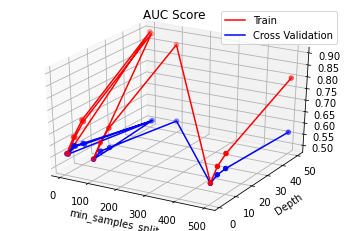

In [28]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
ax.plot3D(S_X, D_Y, train_auc, 'red',label='Train')
ax.scatter3D(S_X, D_Y, train_auc,c= "red")
ax.plot3D(S_X, D_Y, cv_auc, 'blue',label='Cross Validation')
ax.scatter3D(S_X, D_Y, cv_auc,c= "blue")
plt.title('AUC Score')
plt.xlabel('min_samples_split')
plt.ylabel('Depth')
plt.legend()


In [29]:
print(clf.best_params_)

{'max_depth': 10, 'min_samples_split': 500}


#### 1.5.1.2 Testing the performance of the model on test data, plotting ROC Curves

In [30]:
#here we are choosing the best_alpha based on forloop results
best_max_depth = 10
best_min_samples_split = 500

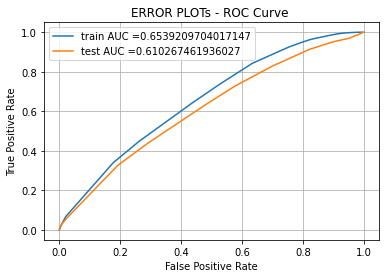

In [31]:
from sklearn.metrics import roc_curve, auc


clf = DecisionTreeClassifier(max_depth=best_max_depth, min_samples_split = best_min_samples_split )
clf.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(clf, X_tr)    
y_test_pred = batch_predict(clf, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

summary.append(['TF-IDF','Decision Tree',"depth:"+str(best_max_depth)+" min_samples_split: "+str(best_min_samples_split),np.round(auc(test_fpr, test_tpr),2)])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTs - ROC Curve ")
plt.grid()
plt.show()

In [32]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [33]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))
#tn, fp, fn, tp = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)).ravel()
#print(tn, fp, fn, tp)


the maximum value of tpr*(1-fpr) 0.36172666870801257 for threshold 0.854
Train confusion matrix
[[ 2019  1576]
 [ 6709 12141]]
Test confusion matrix
[[1365 1277]
 [5040 8818]]


In [34]:
def predict_with_best_t(proba, threshould):
    predictions = []
    if proba>=threshould:
        predictions.append(1)
    else:
        predictions.append(0)
    return predictions

In [35]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
TP=0
FP=0
FN=0
TN=0
indices=[]
for i in range(len(y_test_pred)):
    y_pred=int(predict_with_best_t(y_test_pred[i], best_t)[0])
    if y_test[i]==1 and y_pred==1:
        TP += 1
        indices.append('TP')
    if y_pred==1 and y_test[i]==0:
        FP += 1
        indices.append('FP')
    if y_test[i]==0 and y_pred==0:
        TN += 1
        indices.append('TN')
    if y_pred==0 and y_test[i]==1:
        FN += 1
        indices.append('FN')
print('Test Confusion Matrix')
print('TN : {}\t\tFP : {}\nFN : {}\tTP : {}\n'.format(TN,FP,FN,TP))

the maximum value of tpr*(1-fpr) 0.36172666870801257 for threshold 0.854
Test Confusion Matrix
TN : 1365		FP : 1277
FN : 5040	TP : 8818



In [36]:
FP_indices = [i for i, x in enumerate(indices) if x == "FP"]

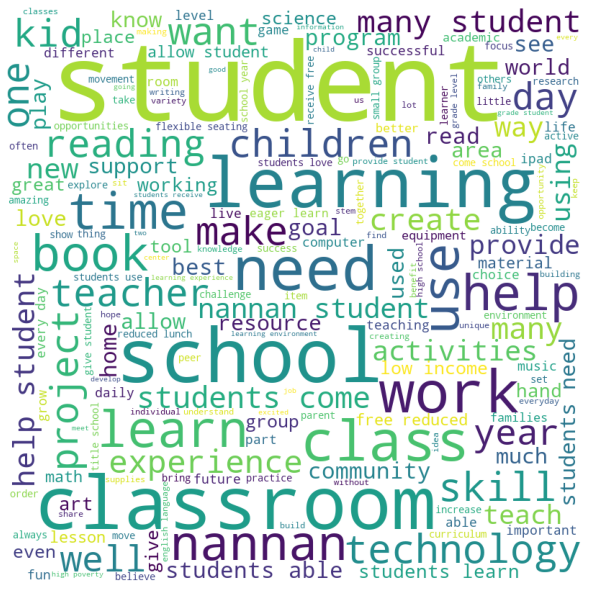

In [37]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
  
comment_words = '' 
stopwords = set(STOPWORDS) 
 
df = X_test.iloc[FP_indices]['essay'].values
# iterate through the csv file 
for val in df: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [38]:
Prices = X_test.iloc[FP_indices]['price'].values

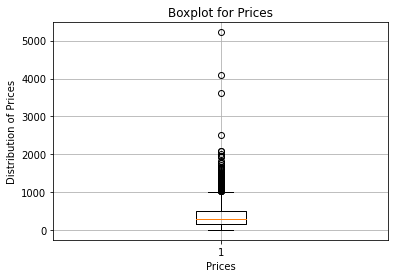

In [39]:
plt.boxplot(Prices)
plt.title('Boxplot for Prices')
plt.xlabel('Prices')
plt.ylabel('Distribution of Prices')
plt.grid()
plt.show()

In [40]:
Prev_Posted = X_test.iloc[FP_indices]['teacher_number_of_previously_posted_projects'].values

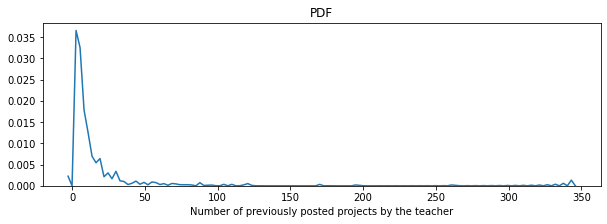

In [41]:
plt.figure(figsize=(10,3))
sns.distplot(Prev_Posted, hist=False)
plt.title('PDF')
plt.xlabel('Number of previously posted projects by the teacher')
plt.show()

#### 2. Task 2

####2.1 Getting important features

In [42]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

feat_imp=[]
clf = DecisionTreeClassifier()
clf.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs


feat_imp.extend(clf.feature_importances_)


In [43]:
feat_nonimp_indices = [i for i, x in enumerate(feat_imp) if x == 0]
len(feat_nonimp_indices)

3708

In [44]:
X_tr_imp = pd.DataFrame(X_tr.todense())
X_cr_imp = pd.DataFrame(X_cr.todense())
X_te_imp = pd.DataFrame(X_te.todense())
X_tr_imp.drop(X_tr_imp.columns[feat_nonimp_indices], axis = 1, inplace = True) 
X_cr_imp.drop(X_cr_imp.columns[feat_nonimp_indices], axis = 1, inplace = True) 
X_te_imp.drop(X_te_imp.columns[feat_nonimp_indices], axis = 1, inplace = True) 

print("Final Data matrix")
print(X_tr_imp.shape, y_train.shape)
print(X_cr_imp.shape, y_cv.shape)
print(X_te_imp.shape, y_test.shape)
print("="*100)

Final Data matrix
(22445, 1397) (22445,)
(11055, 1397) (11055,)
(16500, 1397) (16500,)


<br><h3> 2.2.1 Applying DecisionTreeClassifier: TF-IDF featurization on important features datset</h3>


In [45]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

In [46]:
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV


clf_dt = DecisionTreeClassifier()
parameters = { 'max_depth': [ 1, 5, 10, 50 ],
               'min_samples_split': [ 5, 10, 100, 500 ]}
clf = GridSearchCV(clf_dt, parameters, cv=3, scoring='roc_auc',return_train_score=True)
clf.fit(X_tr_imp, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_min_samples_split'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
S_X =  results['param_min_samples_split']
D_Y =  results['param_max_depth']

results.head()

mean_fit_time  std_fit_time  ...  mean_train_score  std_train_score
0        0.632643      0.003519  ...          0.560632         0.002182
4        2.474566      0.043003  ...          0.615664         0.008863
8        4.591565      0.037676  ...          0.675719         0.012821
12      18.679475      0.661547  ...          0.890713         0.024167
1        0.624235      0.002332  ...          0.560632         0.002182

[5 rows x 18 columns]

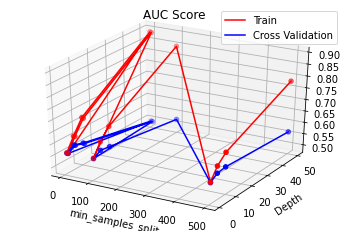

In [47]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
ax.plot3D(S_X, D_Y, train_auc, 'red',label='Train')
ax.scatter3D(S_X, D_Y, train_auc,c= "red")
ax.plot3D(S_X, D_Y, cv_auc, 'blue',label='Cross Validation')
ax.scatter3D(S_X, D_Y, cv_auc,c= "blue")
plt.title('AUC Score')
plt.xlabel('min_samples_split')
plt.ylabel('Depth')
plt.legend()


In [48]:
print(clf.best_params_)

{'max_depth': 10, 'min_samples_split': 500}


#### 2.2.2 Testing the performance of the model on test data, plotting ROC Curves

In [49]:
#here we are choosing the best_alpha based on forloop results
best_max_depth = 10
best_min_samples_split = 500

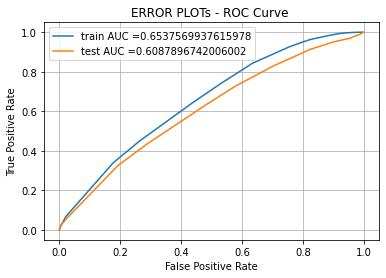

In [50]:
from sklearn.metrics import roc_curve, auc


clf = DecisionTreeClassifier(max_depth=best_max_depth, min_samples_split = best_min_samples_split )
clf.fit(X_tr_imp, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(clf, X_tr_imp)    
y_test_pred = batch_predict(clf, X_te_imp)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

#summary.append(['TF-IDF','Decision Tree',"depth:"+str(best_max_depth)+" min_samples_split: "+str(best_min_samples_split),np.round(auc(test_fpr, test_tpr),2)])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTs - ROC Curve ")
plt.grid()
plt.show()

In [51]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t


In [52]:
def predict_with_best_t(proba, threshould):
    predictions = []
    if proba>=threshould:
        predictions.append(1)
    else:
        predictions.append(0)
    return predictions

best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
TP=0
FP=0
FN=0
TN=0
indices=[]
for i in range(len(y_test_pred)):
    y_pred=int(predict_with_best_t(y_test_pred[i], best_t)[0])
    if y_test[i]==1 and y_pred==1:
        TP += 1
        indices.append('TP')
    if y_pred==1 and y_test[i]==0:
        FP += 1
        indices.append('FP')
    if y_test[i]==0 and y_pred==0:
        TN += 1
        indices.append('TN')
    if y_pred==0 and y_test[i]==1:
        FN += 1
        indices.append('FN')
print('Test Confusion Matrix')
print('TN : {}\t\tFP : {}\nFN : {}\t\tTP : {}\n'.format(TN,FP,FN,TP))


the maximum value of tpr*(1-fpr) 0.36160706551613464 for threshold 0.854
Test Confusion Matrix
TN : 1360		FP : 1282
FN : 5040		TP : 8818



<h2>1.6.1 Make Data Model Ready: encoding essay using TFIDF-W2V</h2>

In [53]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['essay'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [54]:
# TF-IDF Word2Vec
# compute TF-IDF word2vec for each review.
tfidf_w2v_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_train.append(vector)



# TF-IDF Word2Vec
# compute TF-IDF word2vec for each review.
tfidf_w2v_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_cv.append(vector)



# TF-IDF Word2Vec
# compute TF-IDF word2vec for each review.
tfidf_w2v_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_test.append(vector)




100%|██████████| 16500/16500 [00:33<00:00, 499.67it/s]


In [55]:
print(len(tfidf_w2v_vectors_train),len(tfidf_w2v_vectors_train[0]))
print(len(tfidf_w2v_vectors_cv),len(tfidf_w2v_vectors_cv[0]))
print(len(tfidf_w2v_vectors_test),len(tfidf_w2v_vectors_test[0]))

22445 300
11055 300
16500 300


## Concatenating all features

In [56]:
from scipy.sparse import hstack
#In order of the feature_names array
X_tr = hstack((tfidf_w2v_vectors_train, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe, X_train_cat_ohe,X_train_subcat_ohe,  X_train_price_norm, X_train_prev_posted_norm,sentiment_scores_train )).tocsr()
X_cr = hstack((tfidf_w2v_vectors_cv, X_cv_state_ohe, X_cv_teacher_ohe, X_cv_grade_ohe, X_cv_cat_ohe, X_cv_subcat_ohe, X_cv_price_norm, X_cv_prev_posted_norm, sentiment_scores_cv)).tocsr()
X_te = hstack((tfidf_w2v_vectors_test, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe, X_test_cat_ohe, X_test_subcat_ohe, X_test_price_norm, X_test_prev_posted_norm,sentiment_scores_test)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)


Final Data matrix
(22445, 405) (22445,)
(11055, 405) (11055,)
(16500, 405) (16500,)


<br><h3>1.6.2 Applying DecisionTreeClassifier: TFIDF-W2V featurization</h3>


In [57]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

In [58]:
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV


clf_dt = DecisionTreeClassifier()
parameters = { 'max_depth': [ 1, 5, 10, 50 ],
               'min_samples_split': [ 5, 10, 100, 500 ]}
clf = GridSearchCV(clf_dt, parameters, cv=3, scoring='roc_auc',return_train_score=True)
clf.fit(X_tr, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_min_samples_split'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
S_X =  results['param_min_samples_split']
D_Y =  results['param_max_depth']

results.head()

mean_fit_time  std_fit_time  ...  mean_train_score  std_train_score
0        0.732391      0.014295  ...          0.565000         0.001715
4        3.491254      0.018243  ...          0.674534         0.003176
8        8.917083      0.167545  ...          0.827341         0.004925
12      22.661130      0.659885  ...          0.999522         0.000032
1        0.718032      0.002806  ...          0.565000         0.001715

[5 rows x 18 columns]

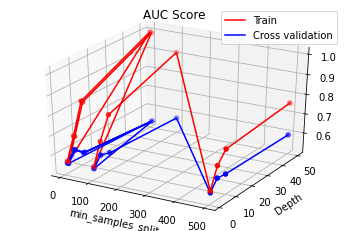

In [59]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
ax.plot3D(S_X, D_Y, train_auc, 'red',label='Train')
ax.scatter3D(S_X, D_Y, train_auc,c= "red")
ax.plot3D(S_X, D_Y, cv_auc, 'blue',label='Cross validation')
ax.scatter3D(S_X, D_Y, cv_auc,c= "blue")
plt.title('AUC Score')
plt.xlabel('min_samples_split')
plt.ylabel('Depth')
plt.legend()


In [60]:
print(clf.best_params_)

{'max_depth': 5, 'min_samples_split': 500}


#### 1.5.1.2 Testing the performance of the model on test data, plotting ROC Curves

In [61]:
#here we are choosing the best_alpha based on forloop results
best_max_depth = 5
best_min_samples_split = 500

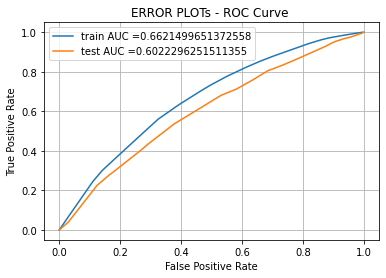

In [62]:
from sklearn.metrics import roc_curve, auc


clf = DecisionTreeClassifier(max_depth=best_max_depth, min_samples_split = best_min_samples_split )
clf.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(clf, X_tr)    
y_test_pred = batch_predict(clf, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

summary.append(['TFIDF-W2V','Decision Tree',"depth:"+str(best_max_depth)+" min_samples_split: "+str(best_min_samples_split),np.round(auc(test_fpr, test_tpr),2)])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTs - ROC Curve ")
plt.grid()
plt.show()

In [63]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [64]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))
#tn, fp, fn, tp = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)).ravel()
#print(tn, fp, fn, tp)


the maximum value of tpr*(1-fpr) 0.38453921044185296 for threshold 0.849
Train confusion matrix
[[ 2181  1414]
 [ 6902 11948]]
Test confusion matrix
[[1435 1207]
 [5396 8462]]


In [65]:
def predict_with_best_t(proba, threshould):
    predictions = []
    if proba>=threshould:
        predictions.append(1)
    else:
        predictions.append(0)
    return predictions

In [66]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
TP=0
FP=0
FN=0
TN=0
indices=[]
for i in range(len(y_test_pred)):
    y_pred=int(predict_with_best_t(y_test_pred[i], best_t)[0])
    if y_test[i]==1 and y_pred==1:
        TP += 1
        indices.append('TP')
    if y_pred==1 and y_test[i]==0:
        FP += 1
        indices.append('FP')
    if y_test[i]==0 and y_pred==0:
        TN += 1
        indices.append('TN')
    if y_pred==0 and y_test[i]==1:
        FN += 1
        indices.append('FN')
print('Test Confusion Matrix')
print('TN : {}\t\tFP : {}\nFN : {}\tTP : {}\n'.format(TN,FP,FN,TP))

the maximum value of tpr*(1-fpr) 0.38453921044185296 for threshold 0.849
Test Confusion Matrix
TN : 1435		FP : 1207
FN : 5396	TP : 8462



In [67]:
FP_indices = [i for i, x in enumerate(indices) if x == "FP"]

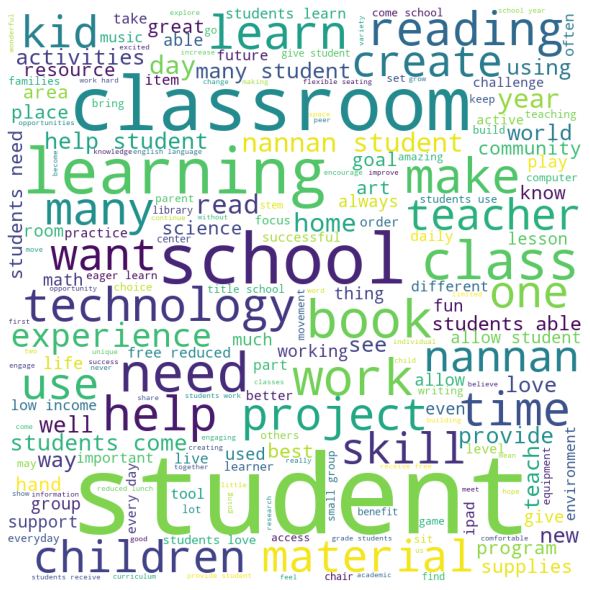

In [68]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
  
comment_words = '' 
stopwords = set(STOPWORDS) 
 
df = X_test.iloc[FP_indices]['essay'].values
# iterate through the csv file 
for val in df: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [69]:
Prices = X_test.iloc[FP_indices]['price'].values

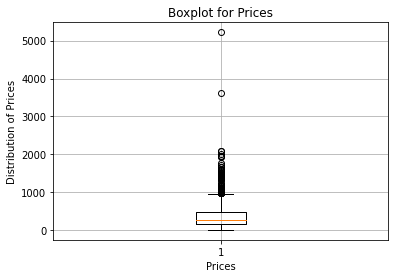

In [70]:
plt.boxplot(Prices)
plt.title('Boxplot for Prices')
plt.xlabel('Prices')
plt.ylabel('Distribution of Prices')
plt.grid()
plt.show()

In [71]:
Prev_Posted = X_test.iloc[FP_indices]['teacher_number_of_previously_posted_projects'].values

No handles with labels found to put in legend.


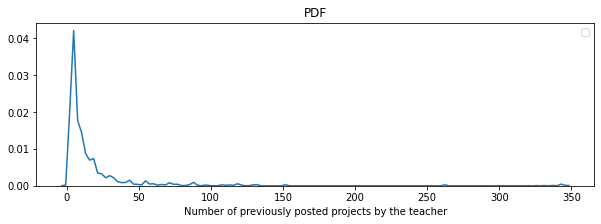

In [72]:
plt.figure(figsize=(10,3))
sns.distplot(Prev_Posted, hist=False)
plt.title('PDF')
plt.xlabel('Number of previously posted projects by the teacher')
plt.legend()
plt.show()

### **3.Summary** 

In [78]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hyper Parameter", "AUC"]

for i in range(0,3,2):
    x.add_row([summary[i][0],summary[i][1],summary[i][2],summary[i][3]])
print(x)

+------------+---------------+---------------------------------+------+
| Vectorizer |     Model     |         Hyper Parameter         | AUC  |
+------------+---------------+---------------------------------+------+
|   TF-IDF   | Decision Tree | depth:10 min_samples_split: 500 | 0.61 |
| TFIDF-W2V  | Decision Tree |  depth:5 min_samples_split: 500 | 0.6  |
+------------+---------------+---------------------------------+------+
